In [ ]:
import dolfin as dl
import ufl
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "../../../") )
sys.path.append("../../../")
sys.path.append("../")
from hippylib import *
sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "..") + "/applications/ad_diff/" )
from applications.ad_diff.model_ad_diff_bwd import TimeDependentAD, SpaceTimePointwiseStateObservation
from fourier import *
from bcs import *
import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

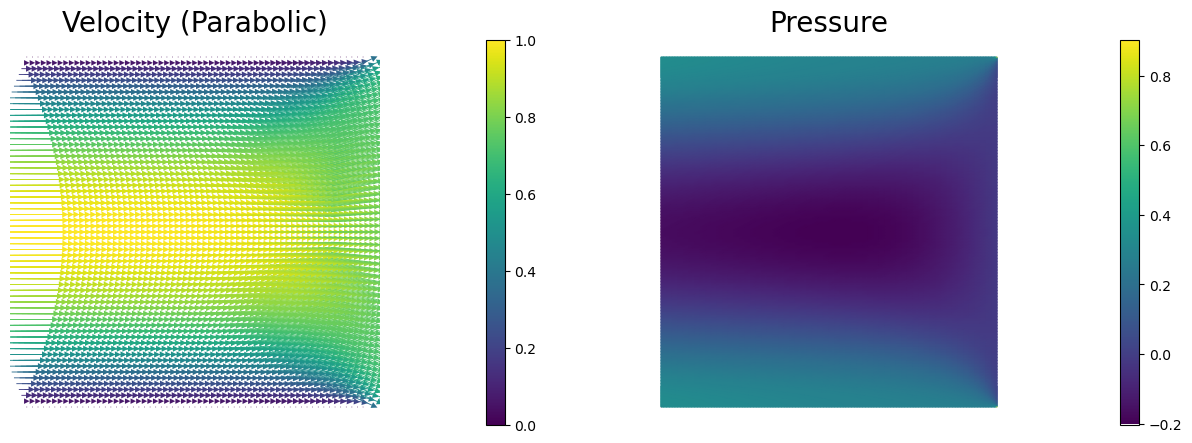

Number of dofs: 21103


In [54]:
nx, ny = 60, 120
mesh = dl.UnitSquareMesh(nx, ny)

for _ in range(2):  
    markers = dl.MeshFunction("bool", mesh, mesh.topology().dim())
    markers.set_all(False)

    for cell in dl.cells(mesh):
        y = cell.midpoint().y()
        if y < 0.06 or y > 0.94:     
            markers[cell] = True

    mesh = dl.refine(mesh, markers)

wind_velocity = computeVelocityField(mesh)
Vh = dl.FunctionSpace(mesh, "Lagrange", 1)
print("Number of dofs: {0}".format(Vh.dim()))

Number of observation points: 16


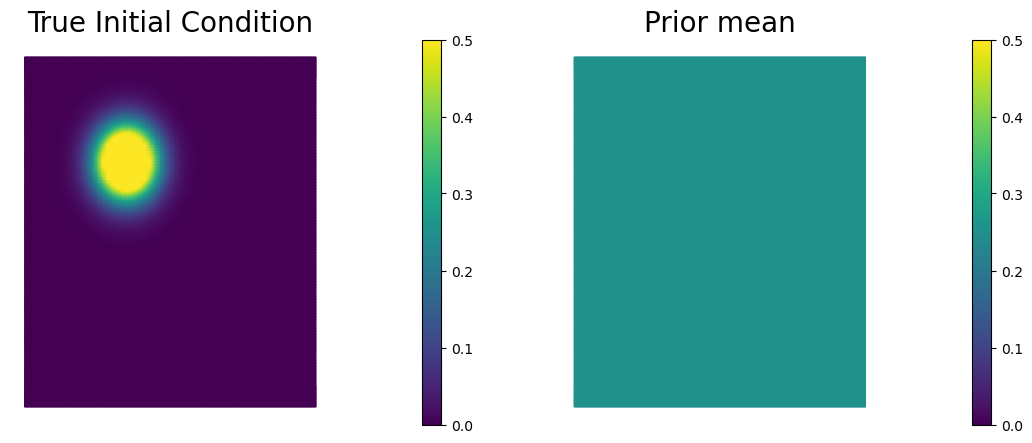

In [56]:
ic_expr = dl.Expression(
    'std::min(0.5, std::exp(-100*(std::pow(x[0]-0.35,2) + std::pow(x[1]-0.7,2))))',
    element=Vh.ufl_element()
)
true_initial_condition = dl.interpolate(ic_expr, Vh).vector()

gamma = 1.
delta = 8.
prior = BiLaplacianPrior(Vh, gamma, delta, robin_bc=True)
prior.mean = dl.interpolate(dl.Constant(0.25), Vh).vector()

t_init = 0.
t_final = 4.
t_1 = 1.
dt = .1
observation_dt = .2

simulation_times = np.arange(t_init, t_final + .5*dt, dt)
observation_times = np.arange(t_1, t_final + .5*dt, observation_dt)

Ty = (t_1, t_final)
Nf = 3
omegas = fourier_frequencies(Ty, Nf)
coeffs_v = np.array([
    [ 0.05,  0.00],
    [ 0.02,  0.01],
    [ 0.01, -0.01],
], dtype=float)

coeffs_w = np.array([
    [ 0.00,  0.10],
    [ 0.00,  0.05],
    [ 0.00, -0.02],
], dtype=float)

x0 = np.array([0.35, 0.70], dtype=float)  
theta0 = 0.0                              

targets = integrate_unicycle_path(
    observation_times,
    x0=x0,
    theta0=theta0,
    omegas=omegas,
    coeffs_v=coeffs_v,
    coeffs_w=coeffs_w,
    v0=.15,
    w0=.10,
    eps=1e-3,
    substeps=20
)

print("Number of observation points:", targets.shape[0])
assert targets.shape[0] == len(observation_times)

misfit = SpaceTimePointwiseStateObservation(Vh, observation_times, targets)



problem = TimeDependentAD(mesh, [Vh, Vh, Vh], prior, misfit, simulation_times, wind_velocity, True)

objs = [
    dl.Function(Vh, true_initial_condition),
    dl.Function(Vh, prior.mean)
]
mytitles = ["True Initial Condition", "Prior mean"]
nb.multi1_plot(objs, mytitles)
plt.show()

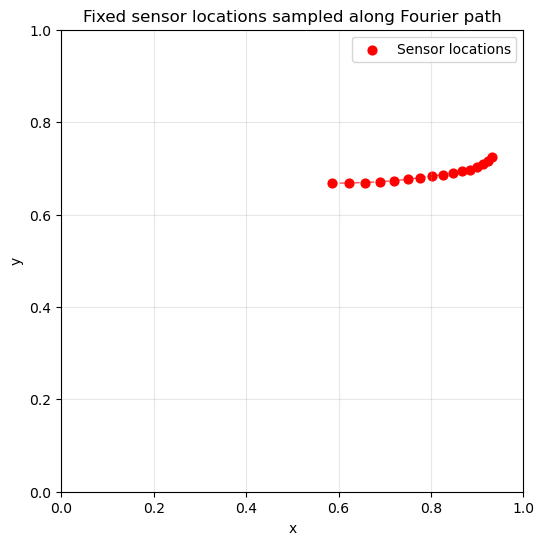

In [ ]:
plot_targets(targets, 'fourier_x.pdf')

In [ ]:
rel_noise = 0.01
utrue = problem.generate_vector(STATE)
x = [utrue, true_initial_condition, None]
problem.solveFwd(x[STATE], x)
misfit.observe(x, misfit.d)
MAX = misfit.d.norm("linf", "linf")
noise_std_dev = rel_noise * MAX
parRandom.normal_perturb(noise_std_dev, misfit.d)
misfit.noise_variance = noise_std_dev * noise_std_dev
nb.show_solution(Vh, true_initial_condition, utrue, "Solution (True + Noisy Observations)")


In [ ]:
[u, m, p] = problem.generate_vector()

# (Optional) make it explicit like Code A usually implies:
# m.zero()

problem.solveFwd(u, [u, m, p])
problem.solveAdj(p, [u, m, p])

mg = problem.generate_vector(PARAMETER)
grad_norm = problem.evalGradientParameter([u, m, p], mg)

print("(g,g) = ", grad_norm)


(g,g) =  2.9943396444659816e+16


Single Pass Algorithm. Requested eigenvectors: 80; Oversampling 20.


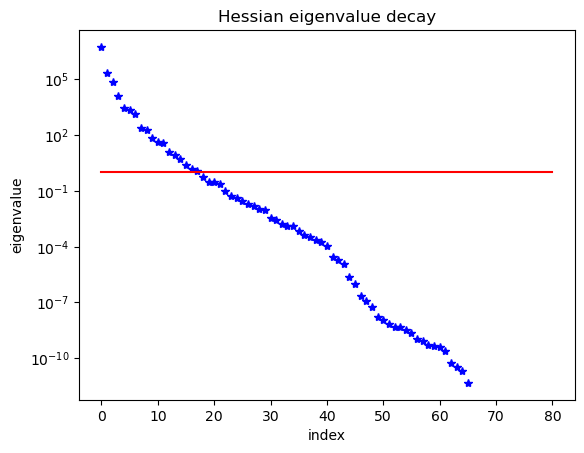

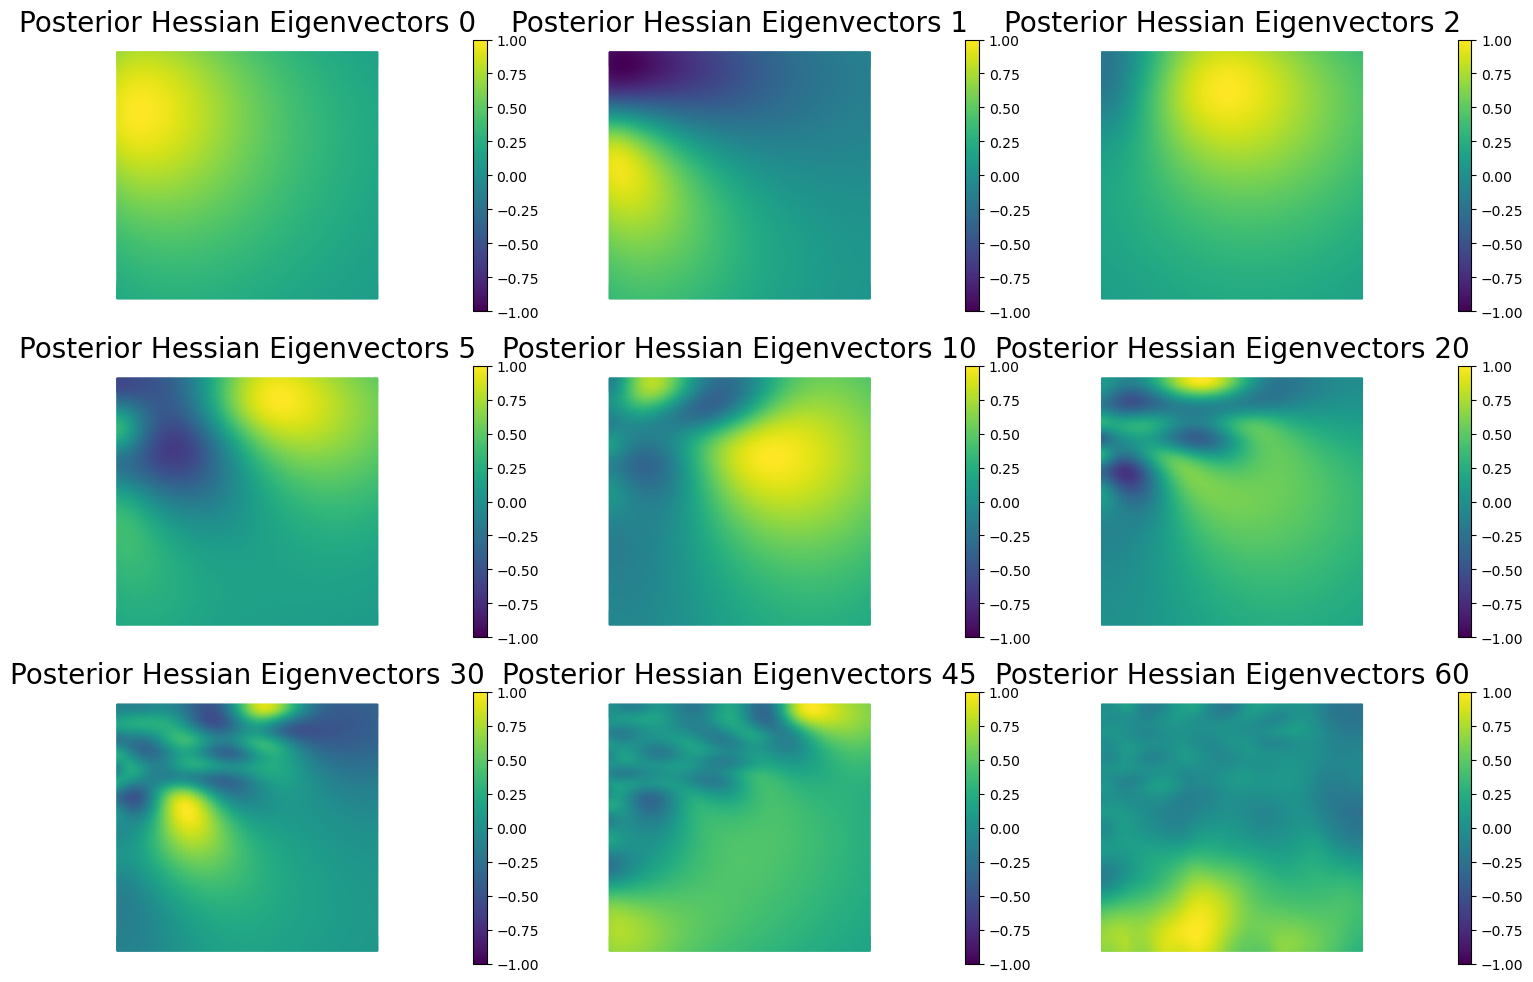

In [ ]:
u_lin = problem.generate_vector(STATE)
x_lin = [u_lin, m, None]

problem.solveFwd(x_lin[STATE], x_lin)

H = ReducedHessian(problem, misfit_only=True)

k = 80
p = 20
print("Single Pass Algorithm. Requested eigenvectors: {0}; Oversampling {1}."
      .format(k, p))

Omega = MultiVector(x_lin[PARAMETER], k + p)
parRandom.normal(1.0, Omega)

lmbda, V = singlePassG(H, prior.R, prior.Rsolver, Omega, k)

posterior = GaussianLRPosterior(prior, lmbda, V)
plot_eigenvalues(lmbda,k, Vh, V)


 Iterartion :  0  (B r, r) =  258518.31327414874
 Iteration :  1  (B r, r) =  0.01526834989777718
 Iteration :  2  (B r, r) =  5.31771071017821e-07
 Iteration :  3  (B r, r) =  7.313645516235146e-12
Relative/Absolute residual less than tol
Converged in  3  iterations with final norm  2.704375254330498e-06
Total cost 517.412; Reg Cost 81.6844; Misfit 435.727


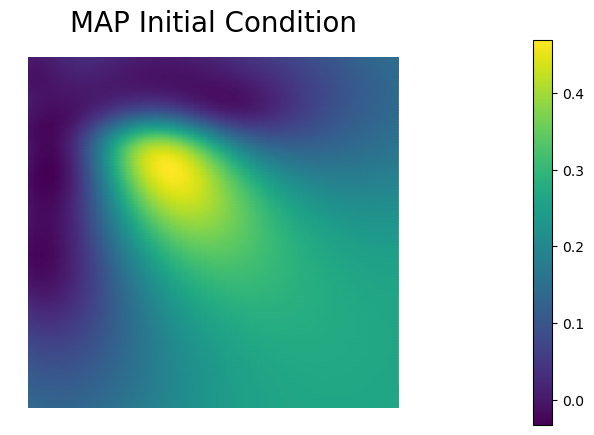

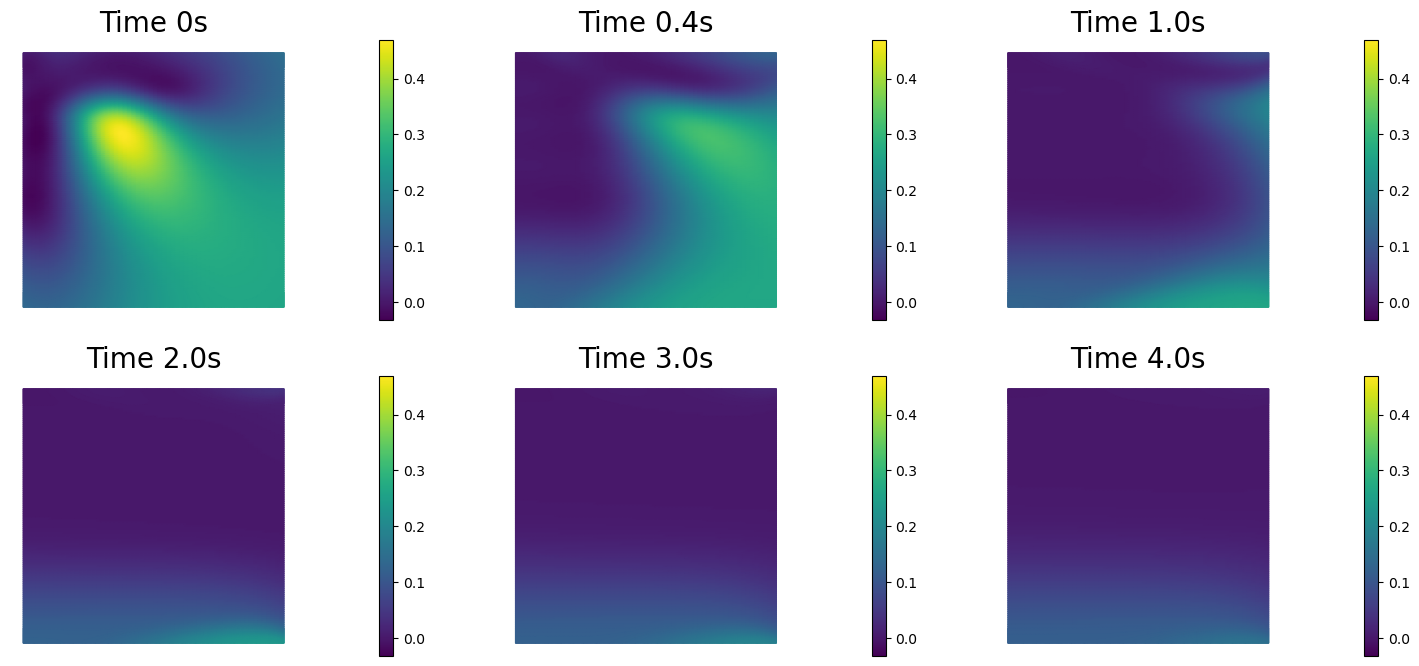

In [ ]:
H.misfit_only = False

solver = CGSolverSteihaug()
solver.set_operator(H)
solver.set_preconditioner(posterior.Hlr)

solver.parameters["print_level"] = 1
solver.parameters["rel_tolerance"] = 1e-6

solver.solve(m, -mg)
try:
    u
    p
except NameError:
    u = problem.generate_vector(STATE)
    p = problem.generate_vector(ADJOINT)

problem.solveFwd(u, [u, m, p])
total_cost, reg_cost, misfit_cost = problem.cost([u, m, p])
print("Total cost {0:5g}; Reg Cost {1:5g}; Misfit {2:5g}".format(total_cost, reg_cost, misfit_cost))

posterior.mean = m

plt.figure(figsize=(7.5, 5))
nb.plot(dl.Function(Vh, m), mytitle="MAP Initial Condition") 
plt.show()

nb.show_solution(Vh, m, u, "Solution at MAP")
plt.show()


Posterior trace 0.00408878; Prior trace 0.010428; Correction trace 0.0063392


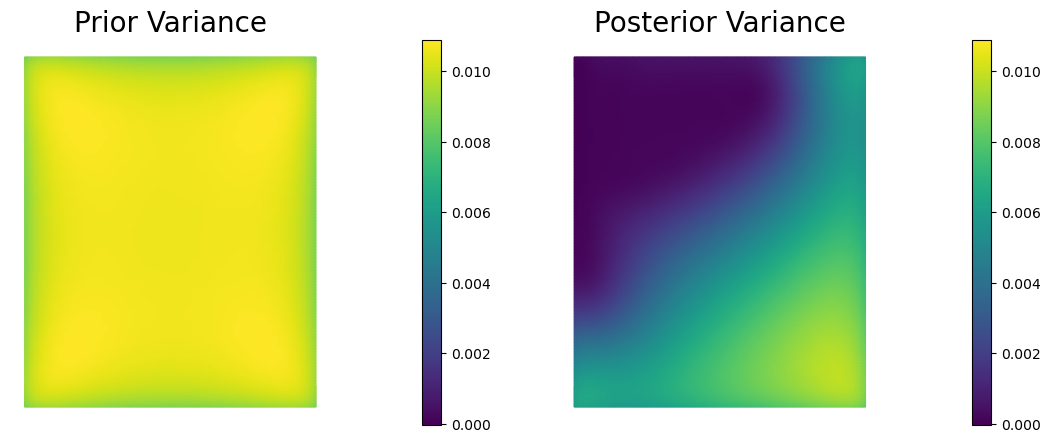

In [ ]:
compute_trace = True
if compute_trace:
    post_tr, prior_tr, corr_tr = posterior.trace(method="Randomized", r=300)
    print( "Posterior trace {0:5g}; Prior trace {1:5g}; Correction trace {2:5g}".format(post_tr, prior_tr, corr_tr) )
post_pw_variance, pr_pw_variance, corr_pw_variance = posterior.pointwise_variance(method="Randomized", r=300)

objs = [dl.Function(Vh, pr_pw_variance),
        dl.Function(Vh, post_pw_variance)]
mytitles = ["Prior Variance", "Posterior Variance"]
nb.multi1_plot(objs, mytitles, logscale=False)
plt.show()


In [ ]:
def compute_EIG_for_c(c_mask, r=20, oversampling=10):
    """
    Computes EIG(c) = sum_{i=1}^r log(1 + lambda_i)

    Control c enters ONLY through B(c), implemented by selecting targets.
    """

    # ----------------------------
    # Build B(c) via target selection
    # ----------------------------
    targets_c = targets_all[c_mask]

    misfit_c = SpaceTimePointwiseStateObservation(
        Vh, observation_times, targets_c
    )

    # ----------------------------
    # IMPORTANT FIX:
    # ReducedHessian requires noise_variance != None
    # ----------------------------
    rel_noise = 0.01
    misfit_c.noise_variance = rel_noise ** 2

    # ----------------------------
    # Build inverse problem (unchanged)
    # ----------------------------
    problem_c = TimeDependentAD(
        mesh, [Vh, Vh, Vh],
        prior, misfit_c,
        simulation_times,
        wind_velocity,
        True
    )

    # ----------------------------
    # Reduced Hessian (misfit only)
    # ----------------------------
    H = ReducedHessian(problem_c, misfit_only=True)

    k = r
    p = oversampling

    # Randomized eigensolver setup
    m_template = problem_c.generate_vector(PARAMETER)
    Omega = MultiVector(m_template, k + p)
    parRandom.normal(1.0, Omega)

    # Generalized eigenpairs
    lmbda, V = singlePassG(
        H, prior.R, prior.Rsolver, Omega, k
    )

    # ----------------------------
    # Expected Information Gain
    # ----------------------------
    EIG = float(np.sum(np.log(1.0 + np.array(lmbda))))

    return EIG, lmbda, V


In [ ]:
# =========================
# EIG evaluation for a test control c
# =========================

# Example control c: activate the first 30 sensors
N = targets_all.shape[0]
c_mask = np.zeros(N, dtype=bool)
c_mask[:30] = True

EIG_value, lmbda, V = compute_EIG_for_c(c_mask, r=20, oversampling=10)
print("EIG(c) =", EIG_value)


EIG(c) = 36.395268281383956


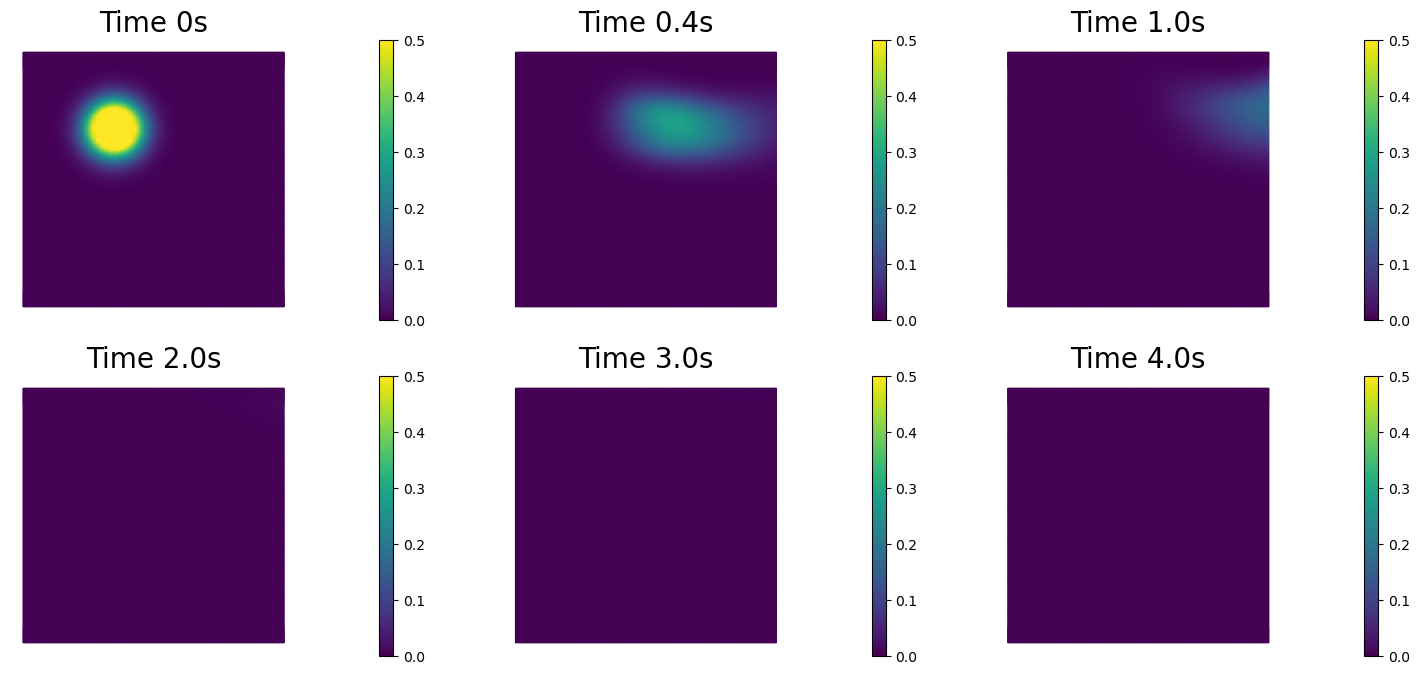

In [ ]:
rel_noise = 0.01
utrue = problem.generate_vector(STATE)
x = [utrue, true_initial_condition, None]
problem.solveFwd(x[STATE], x)
misfit.observe(x, misfit.d)
MAX = misfit.d.norm("linf", "linf")
noise_std_dev = rel_noise * MAX
parRandom.normal_perturb(noise_std_dev,misfit.d)
misfit.noise_variance = noise_std_dev*noise_std_dev

nb.show_solution(Vh, true_initial_condition, utrue, "Solution")

(yy, H xx) - (xx, H yy) =  -6.320097831466688e-14


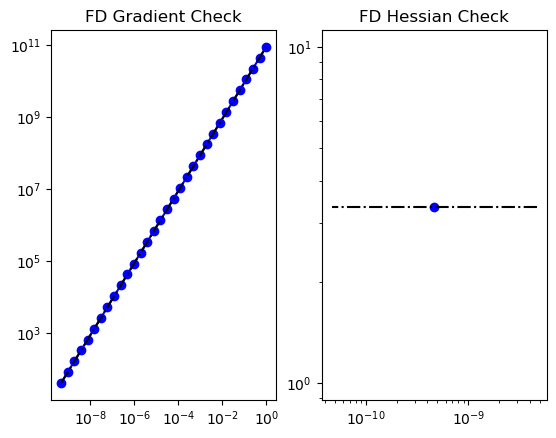

In [ ]:
m0 = true_initial_condition.copy()
_ = modelVerify(problem, m0, is_quadratic=True)

In [ ]:
[u,m,p] = problem.generate_vector()
problem.solveFwd(u, [u,m,p])
problem.solveAdj(p, [u,m,p])
mg = problem.generate_vector(PARAMETER)
grad_norm = problem.evalGradientParameter([u,m,p], mg)

print( "(g,g) = ", grad_norm)

(g,g) =  2.9813932893361996e+16


Single Pass Algorithm. Requested eigenvectors: 80; Oversampling 20.


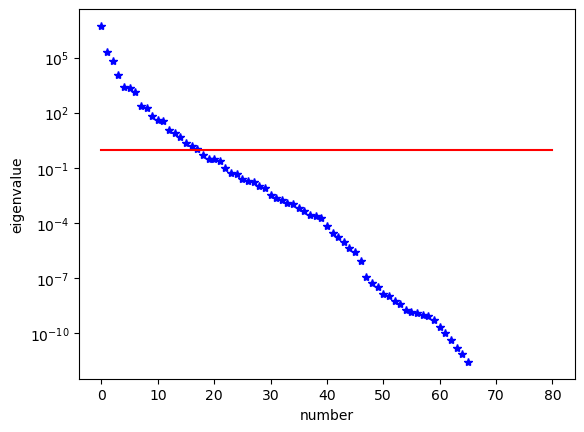

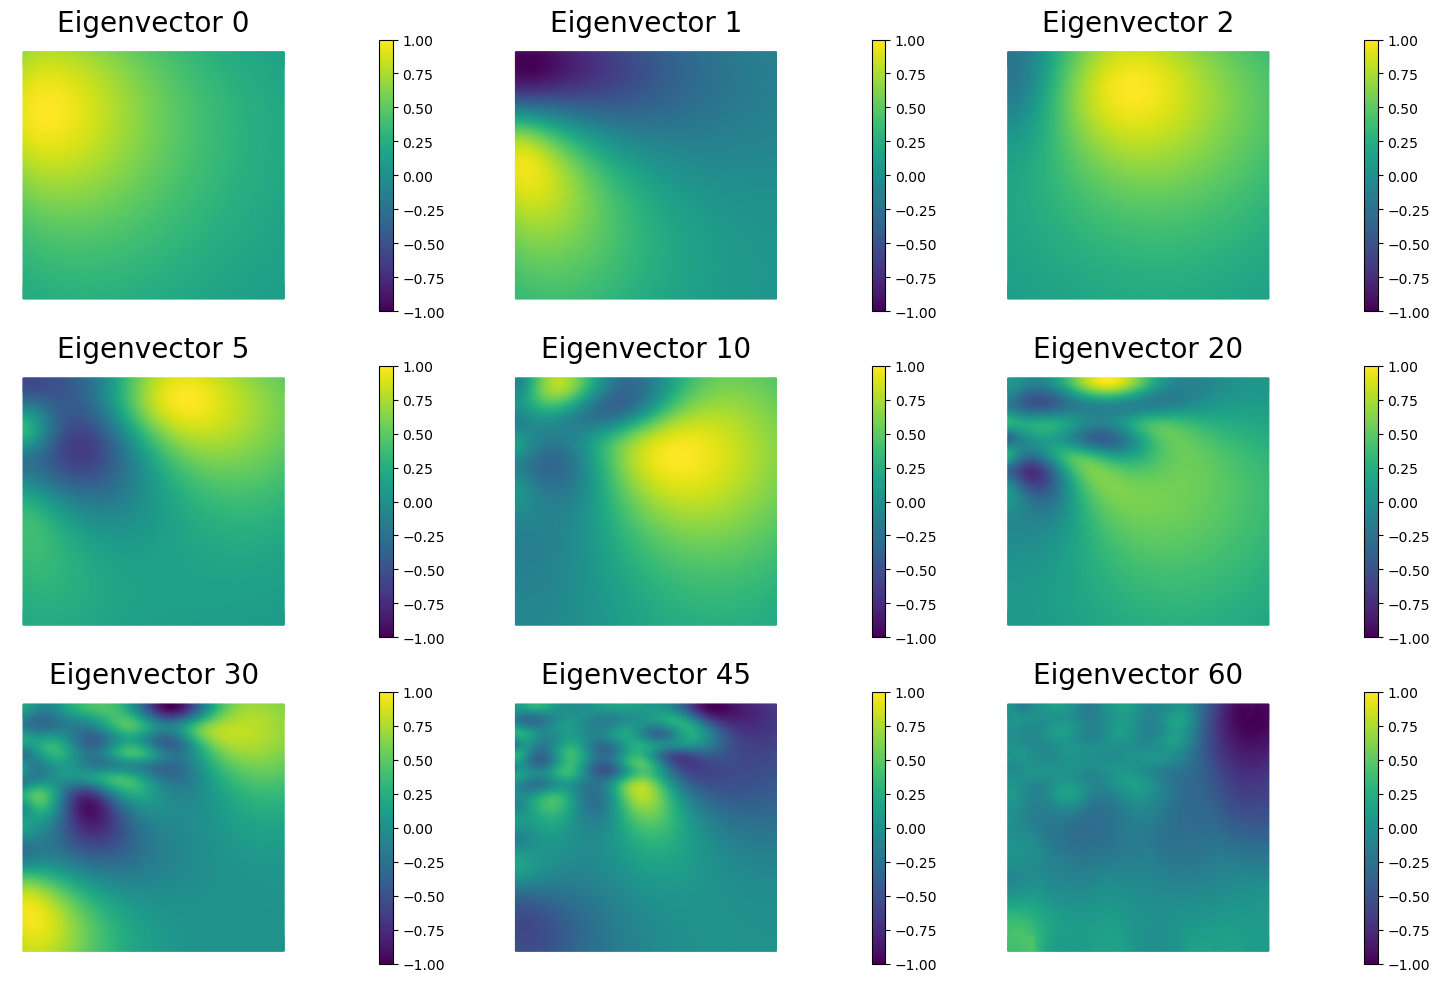

In [ ]:
H = ReducedHessian(problem, misfit_only=True) 

k = 80
p = 20
print( "Single Pass Algorithm. Requested eigenvectors: {0}; Oversampling {1}.".format(k,p) )
Omega = MultiVector(x[PARAMETER], k+p)
parRandom.normal(1., Omega)
lmbda, V = singlePassG(H, prior.R, prior.Rsolver, Omega, k)


posterior = GaussianLRPosterior( prior, lmbda, V )

plt.plot(range(0,k), lmbda, 'b*', range(0,k+1), np.ones(k+1), '-r')
plt.yscale('log')
plt.xlabel('number')
plt.ylabel('eigenvalue')

nb.plot_eigenvectors(Vh, V, mytitle="Eigenvector", which=[0,1,2,5,10,20,30,45,60])

 Iterartion :  0  (B r, r) =  163845452337.31998
 Iteration :  1  (B r, r) =  11551775695.05659
 Iteration :  2  (B r, r) =  3874617463.07067
 Iteration :  3  (B r, r) =  258156356.05554903
 Iteration :  4  (B r, r) =  112125366.2974135
 Iteration :  5  (B r, r) =  6165718.808036759
 Iteration :  6  (B r, r) =  2082038486.3791895
 Iteration :  7  (B r, r) =  587569.2414839227
 Iteration :  8  (B r, r) =  693383.6730143584
 Iteration :  9  (B r, r) =  113373.62623320216
 Iteration :  10  (B r, r) =  497406.4561055586
 Iteration :  11  (B r, r) =  3574817.2589615025
 Iteration :  12  (B r, r) =  112170.69770564212
 Iteration :  13  (B r, r) =  10154.512663411148
 Iteration :  14  (B r, r) =  10243.440396790975
 Iteration :  15  (B r, r) =  8529466.268693484
 Iteration :  16  (B r, r) =  6442.162830915468
 Iteration :  17  (B r, r) =  68516.20259182954
 Iteration :  18  (B r, r) =  37130.38022711882
 Iteration :  19  (B r, r) =  8617.194222556434
 Iteration :  20  (B r, r) =  2379.5699884

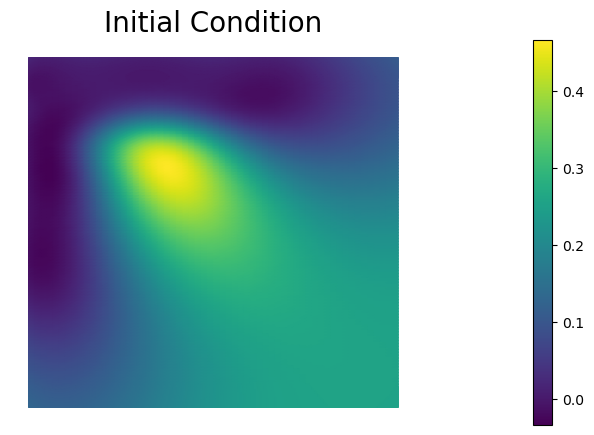

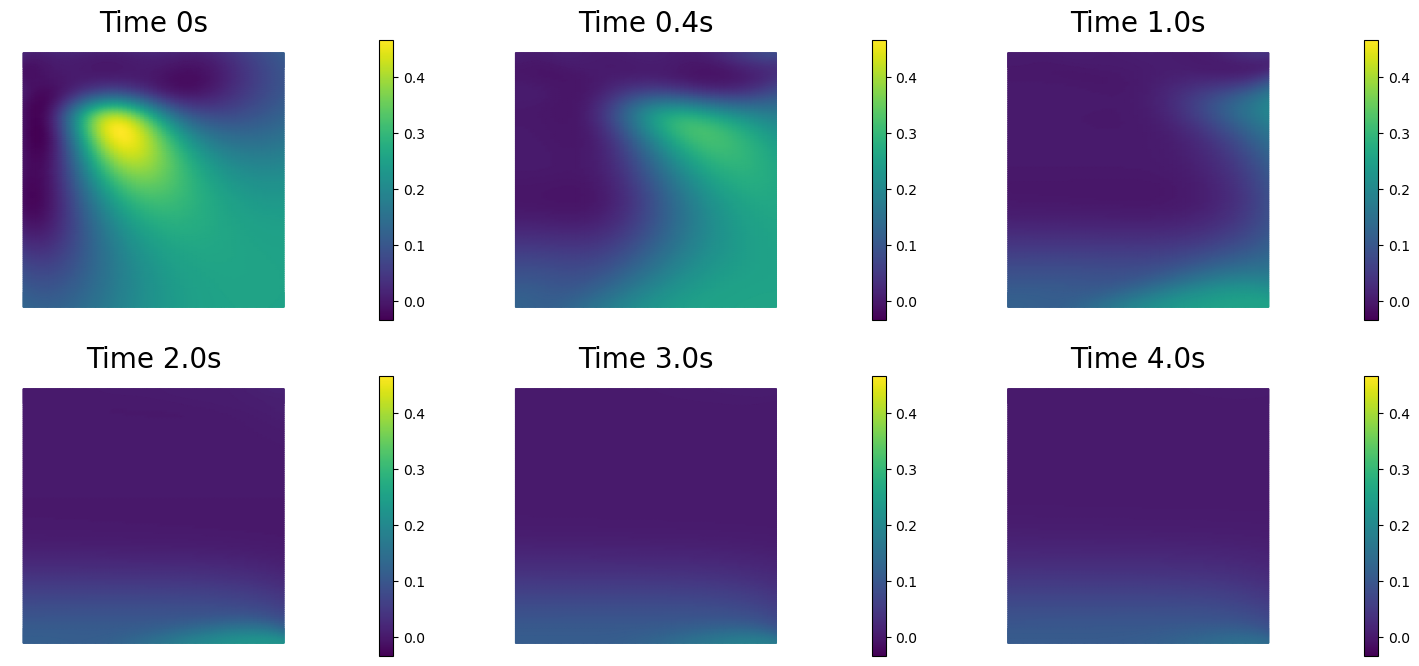

In [ ]:
# -------------------------
# Fixed Newton/CG step
# -------------------------

# Use full Hessian
H.misfit_only = False

# Build RHS = -mg robustly (avoid "-mg")
rhs = mg.copy()
rhs *= -1.0

# Solve for increment dm: H dm = -g
solver = CGSolverSteihaug()
solver.set_operator(H)

# IMPORTANT: use SPD preconditioner (guaranteed) to avoid math-domain errors
solver.set_preconditioner(prior.Rsolver)


solver.parameters["print_level"] = 1
solver.parameters["rel_tolerance"] = 1e-6

dm = problem.generate_vector(PARAMETER)
dm.zero()

solver.solve(dm, rhs)

# Update parameter: m <- m + dm
m.axpy(1.0, dm)

# Forward solve at updated parameter
problem.solveFwd(u, [u, m, p])

# Costs
total_cost, reg_cost, misfit_cost = problem.cost([u, m, p])
print("Total cost {0:5g}; Reg Cost {1:5g}; Misfit {2:5g}".format(total_cost, reg_cost, misfit_cost))

# Store posterior mean safely
posterior.mean = m.copy()

# Robust plot (Vector -> Function)
m_fun = dl.Function(Vh)
m_fun.vector().zero()
m_fun.vector().axpy(1.0, m)

plt.figure(figsize=(7.5, 5))
nb.plot(m_fun, mytitle="Initial Condition")
plt.show()

nb.show_solution(Vh, m, u, "Solution")


In [ ]:
compute_trace = True
if compute_trace:
    post_tr, prior_tr, corr_tr = posterior.trace(method="Randomized", r=300)
    print( "Posterior trace {0:5g}; Prior trace {1:5g}; Correction trace {2:5g}".format(post_tr, prior_tr, corr_tr) )
post_pw_variance, pr_pw_variance, corr_pw_variance = posterior.pointwise_variance(method="Randomized", r=300)

objs = [dl.Function(Vh, pr_pw_variance),
        dl.Function(Vh, post_pw_variance)]
mytitles = ["Prior Variance", "Posterior Variance"]
nb.multi1_plot(objs, mytitles, logscale=False)
plt.show()

Posterior trace 0.00408864; Prior trace 0.010428; Correction trace 0.00633936


KeyboardInterrupt: 